# Détection d'intrusion à l'aide d'un autoencodeur
Nathan TBL

## • Importation des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires et définition d'une fonction pour charger et prétraiter les données en encodant les étiquettes et normalisant les valeurs.

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
import matplotlib.pyplot as plt

In [18]:
#Chargement et preprocessing des données 
def load_and_preprocess_data(file_path, filter_normal=True):
    df = pd.read_csv(file_path, header=None)
    
    df = df.iloc[:, :-1] 

    # Binariser les étiquettes
    labels = (df[df.columns[-1]] != 'normal').astype(int)  # 0 pour 'normal', 1 pour toutes les autres classes
    
    # Filtrer les lignes normales
    if filter_normal:
        df = df[df[df.columns[-1]] == 'normal']
    
    # Si aucune donnée ne reste après le filtrage, cela évitera une erreur lors de la normalisation
    if df.empty:
        return np.array([]), np.array([])
    
    X = df.drop(columns=[df.columns[-1]])
    
    # Encoder les colonnes de type object
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
    
    # Normalisation des données
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, labels


## • Création du Modèle d'Autoencodeur
Définition et compilation du modèle d'autoencodeur avec des couches d'encodage et de décodage. Chargement et prétraitement des données d'entraînement et de test.

In [19]:
def create_autoencoder(input_dim):    
    # Couche d'entrée
    input_layer = Input(shape=(input_dim,))
    
    # Couches d'encodage
    encoded = Dense(512)(input_layer)
    encoded = Dropout(0.5)(encoded)
    encoded = LeakyReLU(0.01)(encoded)
    encoded = Dense(256)(encoded)
    encoded = Dropout(0.5)(encoded)
    encoded = LeakyReLU(0.01)(encoded)
    encoded = Dense(128)(encoded)
    encoded = Dropout(0.5)(encoded)
    encoded = LeakyReLU(0.01)(encoded)
    
    # Bottleneck
    bottleneck = Dense(64)(encoded)
    bottleneck = Dropout(0.5)(bottleneck)
    bottleneck = LeakyReLU(0.01)(bottleneck)
    
    # Couches de décodage
    decoded = Dense(128)(bottleneck)
    decoded = Dropout(0.5)(decoded)
    decoded = LeakyReLU(0.01)(decoded)
    decoded = Dense(256)(decoded)
    decoded = Dropout(0.5)(decoded)
    decoded = LeakyReLU(0.01)(decoded)
    decoded = Dense(512)(decoded)
    decoded = Dropout(0.5)(decoded)
    decoded = LeakyReLU(0.01)(decoded)
    
    # Couche de sortie
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Créer un nouveau modèle
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return autoencoder

In [20]:
# Appel des fonctions de prétraitement et création de l'autoencodeur
train_file_path = './datasets/KDD/KDDTrain+.txt'
test_file_path = './datasets/KDD/KDDTest+.txt'

train_data, train_labels = load_and_preprocess_data(train_file_path, filter_normal=True)
test_data, test_labels = load_and_preprocess_data(test_file_path, filter_normal=False)

autoencoder = create_autoencoder(train_data.shape[1])
print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               21504     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0   

## • Entraînement du Modèle
Entraînement du modèle d'autoencodeur sur les données d'entraînement et traçage des pertes d'entraînement et de validation au fil des époques.

In [21]:
# Entrainement du modèle
history = autoencoder.fit(train_data, train_data, 
                          epochs=30,  # Using 30 epochs as specified
                          batch_size=256,  
                          shuffle=True, 
                          validation_data=(test_data, test_data))

Train on 67343 samples, validate on 22544 samples
Epoch 1/30
67343/67343 [==============================] - 2s 31us/sample - loss: 15.1804 - val_loss: 18.4402
Epoch 2/30
67343/67343 [==============================] - 2s 25us/sample - loss: 14.2605 - val_loss: 17.7808
Epoch 3/30
67343/67343 [==============================] - 2s 25us/sample - loss: 14.0753 - val_loss: 17.4352
Epoch 4/30
67343/67343 [==============================] - 2s 25us/sample - loss: 13.9948 - val_loss: 17.4174
Epoch 5/30
67343/67343 [==============================] - 2s 25us/sample - loss: 13.9440 - val_loss: 17.3120
Epoch 6/30
67343/67343 [==============================] - 2s 25us/sample - loss: 13.9064 - val_loss: 17.2479
Epoch 7/30
67343/67343 [==============================] - 2s 25us/sample - loss: 13.8755 - val_loss: 17.2060
Epoch 8/30
67343/67343 [==============================] - 2s 25us/sample - loss: 13.8532 - val_loss: 17.0471
Epoch 9/30
67343/67343 [==============================] - 2s 29us/sample - los

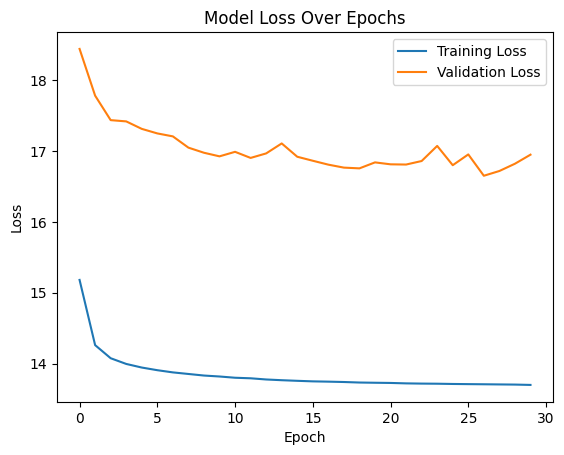

In [22]:
# Afficher le graphique d'entrainement
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## • Inference et Détection des Anomalies / Évaluation des Performances

Prédiction sur les données de test avec l'autoencodeur, calcul de l'erreur quadratique moyenne pour chaque échantillon, et détermination d'un seuil basé sur le 40ème percentile pour détecter les anomalies.

In [23]:
# Inference sur les données de test
X_pred = autoencoder.predict(test_data)

# Calculer l'erreur  moyenne
mse = np.mean(np.power(test_data - X_pred, 2), axis=1)

# Seuil de detection de 40 basé sur le percentile
threshold_value = np.percentile(mse, 40)
print(f"MSE Threshold for {40}th percentile to detect anomalies:", threshold_value)

# Détecter les anomalies (1 si MSE est au-dessus du seuil)
anomalies = mse > threshold_value

# Calculer les métriques pour le seuil sélectionné
print("Metrics for the selected threshold:")
print("Confusion Matrix:")
print(confusion_matrix(test_labels, anomalies))
print("Accuracy:", accuracy_score(test_labels, anomalies))
print("Precision:", precision_score(test_labels, anomalies))
print("Recall:", recall_score(test_labels, anomalies))

MSE Threshold for 40th percentile to detect anomalies: 0.002049649713781928
Metrics for the selected threshold:
Confusion Matrix:
[[ 7871  1840]
 [ 1147 11686]]
Accuracy: 0.8675035486160397
Precision: 0.8639656956971759
Recall: 0.91062105509234


In [24]:
# Sauvegarder le modèle
autoencoder.save('autoencoder_network_trafic_model.h5')